In [32]:
#Set paths to parquet and edges data
import pandas as pd
import numpy as np


data = pd.read_parquet('../results/kis_viability_filt.parquet')
edges_df = pd.read_csv('../results/kinome.edgelist', names=['source', 'target'])

In [33]:
#Removing missing inhibition states

import torch
import torch_geometric
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv




def load_and_process_data(edge_df, parquet_df):
    edges_df = edge_df

    data = parquet_df


    measured_kinases = [col[4:] for col in data.columns if col.startswith('inh_')]
    print("\nKinase statistics:")
    print(f"Number of measured kinases: {len(measured_kinases)}")
    print("First 5 measured kinases:", measured_kinases[:5])

    edges_df_filtered = edges_df[
        (edges_df['source'].isin(measured_kinases)) &
        (edges_df['target'].isin(measured_kinases))
    ]
    network_kinases = set(measured_kinases) #set(edges_df_filtered['source']) | set(edges_df_filtered['target'])

    # 2) prune your feature list to match
    surviving_kinases = [k for k in measured_kinases if k in network_kinases]
    print(f"After pruning: {len(measured_kinases)} kinases (should equal unique nodes)")

    # 3) rebuild the kinase → index map
    kinase_to_idx = {k: i for i, k in enumerate(surviving_kinases)}

    # 4) rebuild edge_index using only the surviving kinases
    edge_index = torch.tensor([
        [kinase_to_idx[s] for s in edges_df_filtered['source']],
        [kinase_to_idx[t] for t in edges_df_filtered['target']]
    ], dtype=torch.long)
    print("\nEdge index statistics:")
    print(f"Edge index shape: {edge_index.shape}")
    print("First 5 edges (node indices):", edge_index[:, :5])

    print("\nVerifying data consistency:")
    print(f"Number of kinase features in data: {len(surviving_kinases)}")
    print(f"Number of unique nodes in edge_index: {len(torch.unique(edge_index))}")

    return data, edge_index, kinase_to_idx, surviving_kinases



data, edge_index, kinase_to_idx, measured_kinases = load_and_process_data(edges_df, data)


Kinase statistics:
Number of measured kinases: 237
First 5 measured kinases: ['AAK1', 'ABL1', 'ABL2', 'ACVR1', 'ACVR1B']
After pruning: 237 kinases (should equal unique nodes)

Edge index statistics:
Edge index shape: torch.Size([2, 1975])
First 5 edges (node indices): tensor([[146, 146, 146, 146, 146],
        [236, 207, 102,  10, 144]])

Verifying data consistency:
Number of kinase features in data: 237
Number of unique nodes in edge_index: 234


In [34]:
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import SAGEConv, BatchNorm, GlobalAttention
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.nn.aggr import AttentionalAggregation


# 1) Feature columns for the surviving kinases:
feature_cols = [f'inh_{k}' for k in measured_kinases]

# 2) Dataset class
class KinomeDataset(Dataset):
    def __init__(self, df, edge_index, feature_cols):
        super().__init__()
        self._indices     = None
        self.df           = df
        self.edge_index   = edge_index
        self.feature_cols = feature_cols

    def len(self):
        return len(self.df)

    def get(self, idx):
        row = self.df.iloc[idx]
        x = torch.from_numpy(
                row[self.feature_cols]
                   .to_numpy(dtype=np.float32, copy=False)
            ).unsqueeze(1)                  # [num_nodes, 1]
        y = torch.tensor(row['viability'], dtype=torch.float32)  # scalar
        return Data(x=x, edge_index=self.edge_index, y=y)

    __getitem__ = get



In [35]:
class KinomeGNN(torch.nn.Module):
    def __init__(self, hidden=32, p_drop=0.4):
        super().__init__()
        self.conv1 = SAGEConv(1, hidden)
        self.bn1   = BatchNorm(hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.bn2   = BatchNorm(hidden)
        self.drop  = torch.nn.Dropout(p_drop)
        self.pool  = AttentionalAggregation(torch.nn.Linear(hidden, 1))
        self.lin   = torch.nn.Linear(hidden, 1)

    def forward(self, x, edge_index, batch):
        x = self.drop(F.relu(self.bn1(self.conv1(x, edge_index))))
        x = self.drop(F.relu(self.bn2(self.conv2(x, edge_index))))
        g = self.pool(x, batch)
        return torch.sigmoid(self.lin(g).squeeze(1))

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.auto import tqdm

def run_epoch(loader, model, optimizer=None, scheduler=None, train=True, desc=None):
    if train: model.train()
    else:     model.eval()

    total_loss, count = 0.0, 0

    for batch in tqdm(loader, desc=desc, leave=False):
        batch = batch.to(device)
        if train: optimizer.zero_grad()
        out  = model(batch.x, batch.edge_index, batch.batch)
        loss = F.mse_loss(out, batch.y)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        count     += batch.num_graphs

    if train and scheduler is not None:
        scheduler.step()
    return total_loss / count



=== Fold 1/10 ===


Fold 1 Ep01 | train MSE: 0.1184 | val MSE: 0.1034
Fold 1 R² = 0.0751

=== Fold 2/10 ===


Fold 2 Ep01 | train MSE: 0.1227 | val MSE: 0.1025
Fold 2 R² = 0.0791

GNN 10-Fold CV R²: 0.0771 ± 0.0020


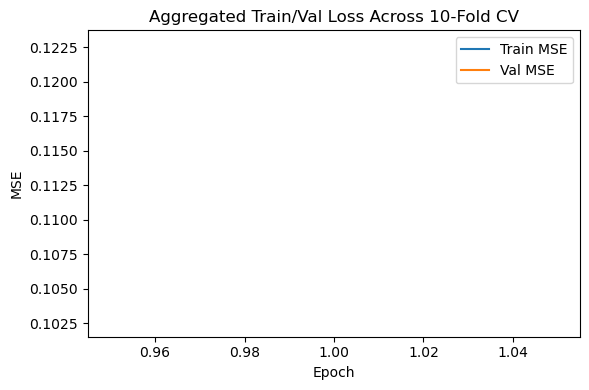

In [ ]:
# ── Cell: 10-Fold CV with OneCycleLR and Progress Bars ─────────────
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, root_mean_squared_error
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

EPOCHS = 30  # increase for full runs

# build group keys
data['drug_cell_group'] = data['drug'].astype(str) + '_' + data['depmap_id'].astype(str)
groups = data['drug_cell_group'].values

assert_test = pd.read_parquet('../results/kis_viability_filt.parquet')
assert_test['drug_cell_group'] = assert_test['drug'] + "_" + assert_test['depmap_id']
assert data.equals(assert_test)

gkf = GroupKFold(n_splits=10)
r2_scores = []
fold_train_histories = []
fold_val_histories   = []
train_idxes = []
test_idxes  = []
gnn_r2 = []
gnn_rmse = []

for fold, (train_idx, test_idx) in enumerate(
        gkf.split(data, data['viability'], groups=groups), start=1):
    print(f"\n=== Fold {fold}/10 ===")

    train_idxes.append(train_idx)
    test_idxes.append(test_idx)

    # split + standardize
    train_df = data.iloc[train_idx].reset_index(drop=True)
    test_df  = data.iloc[test_idx].reset_index(drop=True)
    mu_feat  = train_df[feature_cols].mean()
    sd_feat  = train_df[feature_cols].std().replace(0,1)
    # y_mean   = train_df['viability'].mean()

    def prep(df):
        df = df.copy()
        df[feature_cols] = (df[feature_cols] - mu_feat) / sd_feat
        # df['viability']  = df['viability'] - y_mean
        return df

    train_df, test_df = prep(train_df), prep(test_df)

    # DataLoaders
    train_ds = KinomeDataset(train_df, edge_index, feature_cols)
    test_ds  = KinomeDataset(test_df,  edge_index, feature_cols)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

    model     = KinomeGNN(hidden=32, p_drop=0.4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-3)
    total_steps = EPOCHS * len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-4,
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        final_div_factor=100
    )

    train_hist, val_hist = [], []

    best_val = float('inf')

    for epoch in trange(1, EPOCHS+1, desc=f"Fold {fold}", leave=False):
        # training
        model.train()
        tr_loss, tr_count = 0.0, 0
        for batch in tqdm(train_loader, desc=" train", leave=False):
            batch = batch.to(device)
            optimizer.zero_grad()
            out  = model(batch.x, batch.edge_index, batch.batch)
            loss = torch.nn.functional.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            tr_loss += loss.item() * batch.num_graphs
            tr_count += batch.num_graphs
        tr_mse = tr_loss / tr_count

        # validation
        model.eval()
        va_loss, va_count = 0.0, 0
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=" val", leave=False):
                batch = batch.to(device)
                out  = model(batch.x, batch.edge_index, batch.batch)
                loss = torch.nn.functional.mse_loss(out, batch.y)
                va_loss += loss.item() * batch.num_graphs
                va_count += batch.num_graphs
        va_mse = va_loss / va_count

        if va_mse < best_val:
          best_val = va_mse
          torch.save(model.state_dict(),
                    f'../results/gnn/best_fold{fold}.pt')

        train_hist.append(tr_mse)
        val_hist.append(va_mse)
        print(f"Fold {fold} Ep{epoch:02d} | train MSE: {tr_mse:.4f} | val MSE: {va_mse:.4f}")

    fold_train_histories.append(train_hist)
    fold_val_histories.append(val_hist)

    # final R² on test fold
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out   = model(batch.x, batch.edge_index, batch.batch)
            y_pred.append(out.cpu().numpy())
            y_true.append(batch.y.cpu().numpy())
    y_true = np.concatenate(y_true) #+ y_mean
    y_pred = np.concatenate(y_pred) #+ y_mean
    fold_r2 = r2_score(y_true, y_pred)
    print(f"Fold {fold} R² = {fold_r2:.4f}")
    r2_scores.append(fold_r2)

    gnn_rmse.append(root_mean_squared_error(y_true, y_pred))
    gnn_r2.append(r2_score(y_true, y_pred))

# summarize CV performance
r2_scores = np.array(r2_scores)
print(f"\nGNN 10-Fold CV R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

# aggregated loss plot
train_arr = np.array(fold_train_histories)
val_arr   = np.array(fold_val_histories)
epochs    = np.arange(1, train_arr.shape[1]+1)
mean_tr   = train_arr.mean(0); std_tr = train_arr.std(0)
mean_va   = val_arr.mean(0);   std_va = val_arr.std(0)

# plt.figure(figsize=(6,4))
# plt.plot(epochs, mean_tr, label='Train MSE')
# plt.fill_between(epochs, mean_tr-std_tr, mean_tr+std_tr, alpha=0.3)
# plt.plot(epochs, mean_va, label='Val MSE')
# plt.fill_between(epochs, mean_va-std_va, mean_va+std_va, alpha=0.3)
# plt.xlabel('Epoch'); plt.ylabel('MSE')
# plt.title('Aggregated Train/Val Loss Across 10-Fold CV')
# plt.legend(); plt.tight_layout(); plt.show()


In [38]:
# aggregated loss plot
gnn_rmse = np.array(gnn_rmse)
gnn_r2 = np.array(gnn_r2)

train_arr = np.array(fold_train_histories)
val_arr   = np.array(fold_val_histories)


# save these to a results file using .pt
torch.save({
    'gnn_rmse': gnn_rmse,
    'gnn_r2': gnn_r2,
    'train_hist': train_arr,
    'val_hist': val_arr
}, '../results/gnn/results.pt')